## import libraries and functions

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import math
import os
import cv2
from czifile import CziFile
from skimage.filters import threshold_otsu, rank
from skimage.morphology import disk, closing, opening, watershed, dilation, erosion
from skimage import exposure
from scipy import ndimage as ndi



warnings.filterwarnings('once')
sns.set(style = 'whitegrid', context = 'poster', font = 'Arial', palette = 'Set2')

if os.environ['COMPUTERNAME'] == 'computer_name':
    folder_base = "D:\\image_analysis\\"
else:
    folder_base ='C:\\image_analysis\\'
    
folder_fig = folder_base + 'figures_all\\'
folder_data = folder_base + 'data\\'


## Load images

(1, 3, 512, 512, 1)


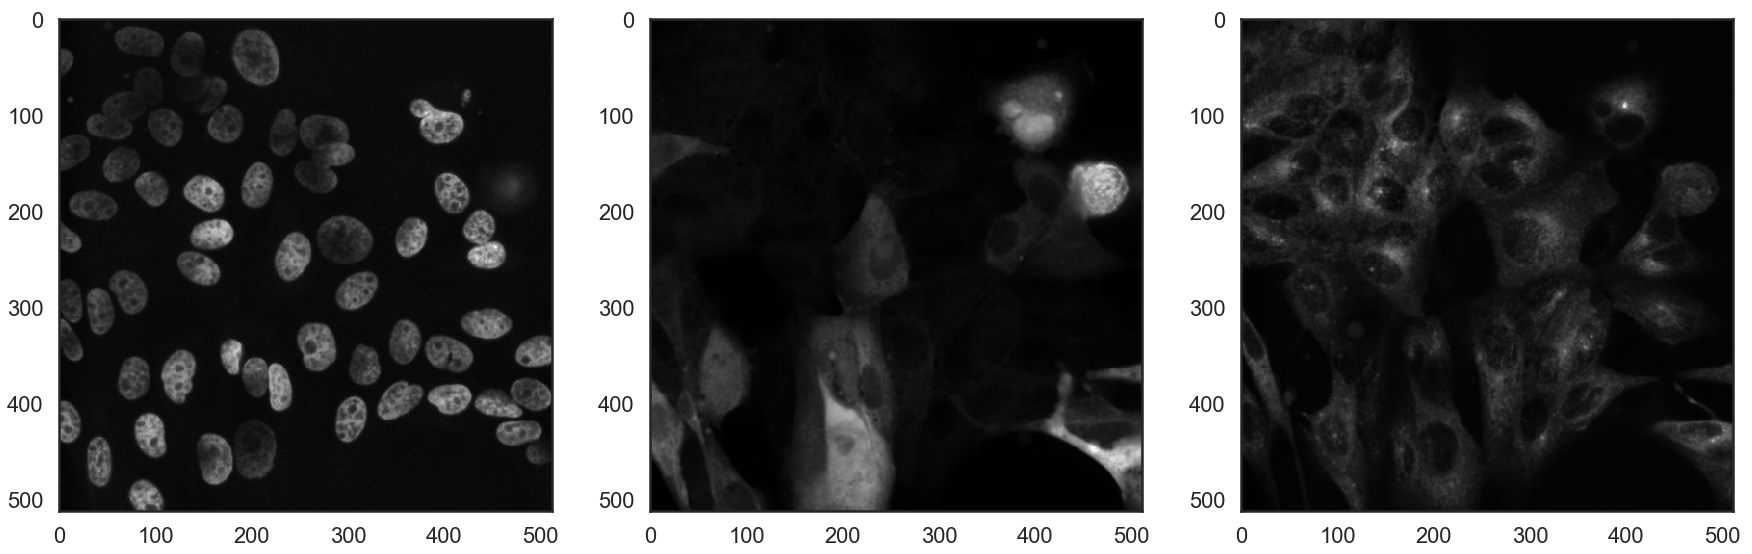

In [187]:
#Channel 0  = DAPI
#Channel 1  = ERKKTR
#Channel 2  = PRKACA


folder_raw = "D:\\raw\\"
file_raw = "image.czi"


with CziFile(folder_raw + file_raw) as czi:
    image_arrays = czi.asarray()

    
print(image_arrays.shape)    
images = [image_arrays[0,index].T[0] for index in range(3)]



N_rows = 1
N_cols = 3
fig, ax_grid = plt.subplots(N_rows, N_cols, figsize=(N_cols*10,N_rows*10))

for col in range(N_cols):
    image = images[col]
    ax_grid[col].imshow(exposure.equalize_adapthist(image), cmap = 'gray')


## Create DAPI masks (Otsu)

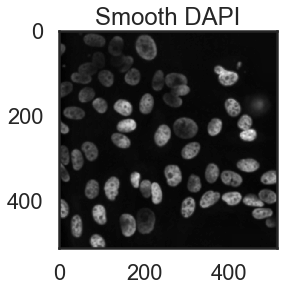

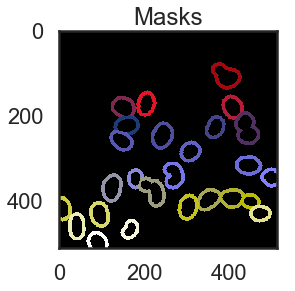

In [182]:
# DNA marker in channel 0
dapi = images[0]

#smooth dapi image
dapi_smooth = cv2.GaussianBlur(dapi, (7,7),0)
plt.imshow(exposure.equalize_adapthist(dapi_smooth), cmap=plt.cm.gray)
plt.title('Smooth DAPI')
plt.show()

#create disk for local Otsu
radius = 200
selem = disk(radius)

#get threshold for local Otsu
local_otsu = rank.otsu(dapi_smooth, selem)

# threshold DAPI image
dapi_thresh  = dapi_smooth > local_otsu * 1.05

#close-open regions
selem2 = disk(2)
selem3 = disk(11)
image2 = closing(dapi_thresh,selem2)
image3 = opening(image2, selem3)

# create masks
masks_n = ndi.label(image3)[0]
masks_c = dilation( ndi.label(image3)[0], disk(9))
masks_c[masks_n>0] = 0

plt.imshow(masks_c, cmap='gist_stern')
#plt.imshow(masks_n, cmap='gist_stern')
plt.title('Masks')
plt.show()


## calculate PRKACA AND ERKKTR in each mask and their ratio

In [248]:
#collect metadata from filename
name = file_raw.split(".")[0]
try:
    image_name = name.split("-")[1]
except IndexError:
    image_name = "01"
    
date, genotype, light, drug = name.split("-")[0].split("_")

635.0

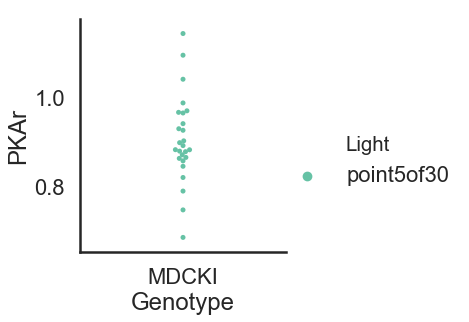

In [265]:

aa=len(df)
for label in np.arange(masks_n.max()):
    df.loc[label,'Date'] = date
    df.loc[label,'Genotype'] = genotype
    df.loc[label,'Light'] = light
    df.loc[label,'Drug'] = drug
    df.loc[label,'Image'] = image_name
    df.loc[label,'Cell'] = label+1
    df.loc[label,'PKAn'] = np.median(pka[masks_n==label+1])
    df.loc[label,'PKAc'] = np.median(pka[masks_c==label+1])
    df.loc[label,'PKAb'] = np.median(pka[(masks_c==0) | (masks_n==0)])
    df.loc[label,'ERKc'] = np.median(erk[masks_c==label+1])
    df.loc[label,'ERKn'] = np.median(erk[masks_n==label+1])
    df.loc[label,'ERKb'] = np.median(erk[(masks_c==0 )| (masks_n==0)])
    df.loc[label,'DAPIn'] = np.median(dapi[masks_c==label+1])
    df.loc[label,'DAPIb'] = np.median(dapi[(masks_c==0 )| (masks_n==0)])
    
    
    aa += 1
    
    
df['PKAr'] = df['PKAn']/df['PKAc']
df['ERKr'] = df['ERKn']/df['ERKc']


sns.catplot(data = df, y='PKAr', x='Genotype', kind ='swarm', hue = 'Light')

## run loop all images

In [954]:
folder_raw = ""
folder_out=""
df = pd.DataFrame(columns=['Date', 'Genotype','Light', 'Drug', 'Image', 'Cell', 'PKAn', 'PKAc', 'PKAr', 'PKAb','ERKn', 'ERKc', 'ERKr','ERKb', 'DAPIn', 'DAPIb'])

all_files = os.listdir(folder_raw)

for file_raw in all_files:
#file_raw = "190228_MDCKI_point5of30_ctrl.czi"

#load image
    with CziFile(folder_raw + file_raw) as czi:
        image_arrays = czi.asarray()  
    images = [image_arrays[0,index].T[0] for index in range(3)]
    dapi =images[0]
    erk =images[1]
    pka =images[2]

    #smooth dapi image
    dapi_smooth = cv2.GaussianBlur(dapi, (7,7), 0)
    
    #get threshold for local Otsu
    local_otsu = rank.otsu(dapi_smooth, disk(200))
    
    #threshold dapi imge
    dapi_thresh  = dapi_smooth > (local_otsu * 1.05)
    image2 = closing(dapi_thresh, disk(2))
    image3 = opening(image2, disk(11))
    
    #create masks
    masks_n = ndi.label(image3)[0]
    masks_c = dilation( ndi.label(image3)[0], disk(9))
    masks_c[masks_n>0] = 0
    
    #save masks
    cv2.imwrite(folder_out + file_raw[:-4] + '-MASKn.tif',masks_n)
    cv2.imwrite(folder_out + file_raw[:-4] + '-MASKc.tif',masks_n)
    
    #collect metadata from filename
    name = file_raw.split(".")[0]
    try:
        image_name = name.split("-")[1]
    except IndexError:
        image_name = "01"
    date, genotype, light, drug = name.split("-")[0].split("_")
    
    #collect data from images  - not efficient
    aa = len(df)
    for label in np.arange(masks_n.max()):
        df.loc[aa,'Date'] = date
        df.loc[aa,'Genotype'] = genotype
        df.loc[aa,'Light'] = light
        df.loc[aa,'Drug'] = drug
        df.loc[aa,'Image'] = image_name
        df.loc[aa,'Cell'] = label+1
        df.loc[aa,'PKAn'] = np.median(pka[masks_n==label+1])
        df.loc[aa,'PKAc'] = np.median(pka[masks_c==label+1])
        df.loc[aa,'PKAb'] = np.median(pka[(masks_c==0) | (masks_n==0)])
        df.loc[aa,'ERKc'] = np.median(erk[masks_c==label+1])
        df.loc[aa,'ERKn'] = np.median(erk[masks_n==label+1])
        df.loc[aa,'ERKb'] = np.median(erk[(masks_c==0 )| (masks_n==0)])
        df.loc[aa,'DAPIn'] = np.median(dapi[masks_c==label+1])
        df.loc[aa,'DAPIb'] = np.median(dapi[(masks_c==0 )| (masks_n==0)])
        aa=aa+1
    
    
#calculate ratios
df['DAPIn'] = df['DAPIn'].astype(np.float)
df['PKAn'] = df['PKAn'].astype(np.float)
df['PKAc'] = df['PKAc'].astype(np.float)
df['PKAr'] = df['PKAn']/df['PKAc']
df['PKAr'] = df['PKAr'].astype(np.float)
df['ERKr'] = df['ERKn']/df['ERKc']
df['ERKr'] = df['ERKr'].astype(np.float)
df['ERKn'] = df['ERKn'].astype(np.float)
df['ERKc'] = df['PKAc'].astype(np.float)

df['DAPIb'] = df['DAPIb'].astype(np.float)
df['nDAPIn'] = df['DAPIn'] - df['DAPIb'] 
df['PKAb'] = df['PKAb'].astype(np.float)
df['nPKAn'] = df['PKAn'] - df['PKAb']
df['nPKAc'] = df['PKAc'] - df['PKAb']
df['nPKAr'] = df['nPKAn']/df['nPKAc']
df['ERKb'] = df['ERKb'].astype(np.float)
df['nERKn'] = df['ERKn']
df['nERKc'] = df['ERKc']
df['nERKr'] = df['nERKn']/df['nERKc']

df['group']  = df['Drug'] + df['Light']


#save dataframe
df.to_csv(folder_out + 'data.csv', index= False)

c:\users\jfonseca\appdata\local\programs\python\python36\lib\site-packages\skimage\filters\rank\generic.py:102: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
c:\users\jfonseca\appdata\local\programs\python\python36\lib\site-packages\skimage\filters\rank\generic.py:102: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
